<a href="https://colab.research.google.com/github/Joana123-collab/Data-Science-I/blob/main/20250410ProyectoI_DataScienceI_JoanaMuchut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Enlace público de Github
url= "https://github.com/Joana123-collab/Data-Science-I/raw/refs/heads/main/DISTRESSDATASET_DATASCIENCE.csv"
df = pd.read_csv(url, on_bad_lines= 'skip', sep=',', encoding='latin-1')

# Mostramos las primeras filas
print(df.head())

   ¿En quiebra?  \
0             1   
1             1   
2             1   
3             1   
4             1   

    ROA(C): Retorno sobre activos (antes de intereses y depreciación)  \
0                                           0.370594                    
1                                           0.464291                    
2                                           0.426071                    
3                                           0.399844                    
4                                           0.465022                    

    ROA(A): Retorno sobre activos (antes de impuestos)  \
0                                           0.424389     
1                                           0.538214     
2                                           0.499019     
3                                           0.451265     
4                                           0.538432     

    ROA(B): Retorno sobre activos (después de impuestos)  \
0                                    

✍**Problema:**
Predecir si una empresa entrará en quiebra basándose en 95 indicadores financieros.

🎯**Objetivo:**
Construir un modelo de clasificación que identifique empresas en riesgo con un Recall > 85% (priorizando detectar la mayor cantidad de quiebras posibles).

🤔**Hipótesis:**
Las variables relacionadas con **deuda ** (X36 - Deuda Total/Patrimonio Neto), **liquidez** (X33 - Ratio de Liquidez Corriente) y **rentabilidad** (X1 - ROA) serán las más relevantes para predecir quiebras.


Proporción de quiebras:
 ¿En quiebra?
0    0.967737
1    0.032263
Name: proportion, dtype: float64


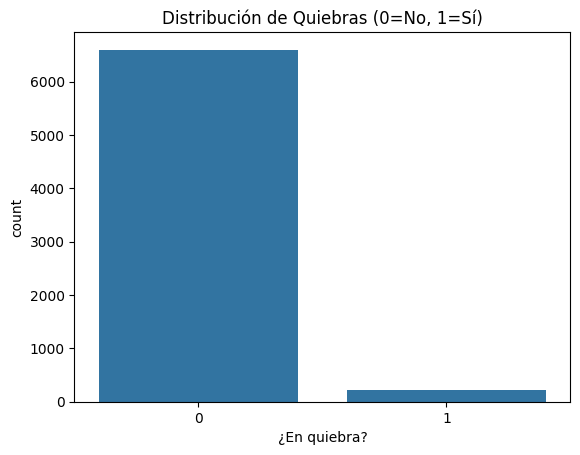

In [14]:
#Variable objetivo
sns.countplot(x='¿En quiebra?', data=df)
plt.title("Distribución de Quiebras (0=No, 1=Sí)")
print("\nProporción de quiebras:\n", df['¿En quiebra?'].value_counts(normalize=True))

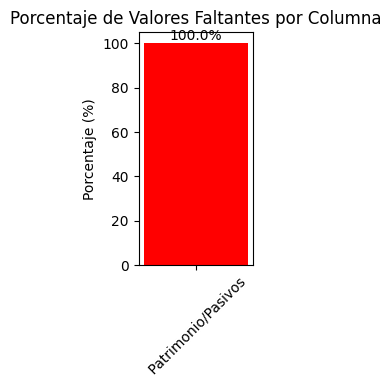

In [26]:
# Calculamos % de nulos por columna
null_pct = df.isnull().mean() * 100
null_pct = null_pct[null_pct > 0]  # Filtrar columnas con nulos

# Gráficamos
plt.figure(figsize=(2, 4))
bars = plt.bar(null_pct.index, null_pct, color='red')

# Añadimos etiquetas con %
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom')

plt.title('Porcentaje de Valores Faltantes por Columna')
plt.xticks(rotation=45)
plt.ylabel('Porcentaje (%)')
plt.tight_layout()
plt.show()

In [32]:
# Lista TODAS las columnas para identificar el nombre correcto
print("Columnas disponibles:\n", df.columns.tolist())

# Alternativa: Buscar columnas con nombres similares
[col for col in df.columns if 'patrimonio' in col.lower() or 'pasivos' in col.lower()]

Columnas disponibles:
 ['¿En quiebra?', ' ROA(C): Retorno sobre activos (antes de intereses y depreciación)', ' ROA(A): Retorno sobre activos (antes de impuestos)', ' ROA(B): Retorno sobre activos (después de impuestos)', ' Margen bruto operativo', ' Margen bruto de ventas realizadas', ' Tasa de beneficio operativo', ' Tasa de interés neto (antes de impuestos)', ' Tasa de interés neto (después de impuestos)', ' Ingresos/gastos no operativos', ' Tasa de interés continua (después de impuestos)', ' % de gastos operativos', ' % de gastos en I+D', ' Ratio de flujo de caja', ' % de deuda con intereses', ' Tasa impositiva (A)', ' Valor contable por acción (B)', ' Valor contable por acción (A)', ' Valor contable por acción (C)', ' EPS persistente (últimos 4 trimestres)', ' Flujo de caja por acción', ' Ingresos por acción (Yuan ¥)', ' Beneficio operativo por acción (Yuan ¥)', ' Beneficio neto por acción (antes de impuestos', ' Yuan ¥)', ' Crecimiento del margen bruto de ventas', ' Crecimiento d

[' Crecimiento del patrimonio neto',
 ' Deuda total/Patrimonio neto',
 ' Patrimonio neto/Activos',
 ' Pasivos contingentes/Patrimonio neto',
 ' Inventario + cuentas por cobrar/Patrimonio neto',
 ' Rotación del patrimonio neto (veces)',
 ' Activos líquidos/Pasivos corrientes',
 ' Efectivo/Pasivos corrientes',
 ' Pasivos corrientes/Activos totales',
 ' Fondos operativos/Pasivos',
 ' Inventario/Pasivos corrientes',
 ' Pasivos corrientes/Pasivos totales',
 ' Capital de trabajo/Patrimonio',
 ' Pasivos corrientes/Patrimonio',
 ' Pasivos a largo plazo/Activos corrientes',
 ' Pasivos corrientes/Pasivos totales.1',
 ' Pasivos corrientes/Patrimonio.1',
 ' Patrimonio/Pasivos a largo plazo',
 ' Flujo de caja/Pasivos',
 ' Flujo de caja/Patrimonio',
 ' Pasivos corrientes/Activos corrientes',
 ' Indicador de riesgo (Pasivos > Activos)',
 ' Beneficio neto/Patrimonio',
 ' Pasivos/Patrimonio',
 ' Patrimonio/Pasivos']

In [35]:
#Buscamos y eliminamos la columna nula (y nos aseguramos dehacerlo chequeando el dataset original vs el nuevo post eliminar nulos)
# Dataset original (96 columnas)
print("Shape original:", df.shape)  # (6819, 96)

# Eliminar columna
df_clean = df.drop(columns=[' Patrimonio/Pasivos'], errors='ignore')

# Verificación
print("Shape después de limpieza:", df_clean.shape)  # (6819, 95) → ¡Se eliminó 1 columna!
print("Columna eliminada:", list(set(df.columns) - set(df_clean.columns)))  # Muestra ['Patrimonio/Pasivos']

Shape original: (6819, 97)
Shape después de limpieza: (6819, 96)
Columna eliminada: [' Patrimonio/Pasivos']



Top 15 variables correlacionadas con quiebra:
 Indicador de riesgo (Pasivos > Activos)                              0.315457
ROA(A): Retorno sobre activos (antes de impuestos)                   0.282941
ROA(B): Retorno sobre activos (después de impuestos)                 0.273051
ROA(C): Retorno sobre activos (antes de intereses y depreciación)    0.260807
Nivel de endeudamiento (%)                                           0.250161
Deuda total/Patrimonio neto                                          0.250161
EPS persistente (últimos 4 trimestres)                               0.219560
Pasivos a largo plazo/Activos corrientes                             0.217779
Beneficio operativo/Capital pagado                                   0.207857
Beneficio neto por acción (antes de impuestos                        0.201395
Efectivo/Pasivos corrientes                                          0.194494
% de asignación por empleado                                         0.193083
Margen bruto/Ven

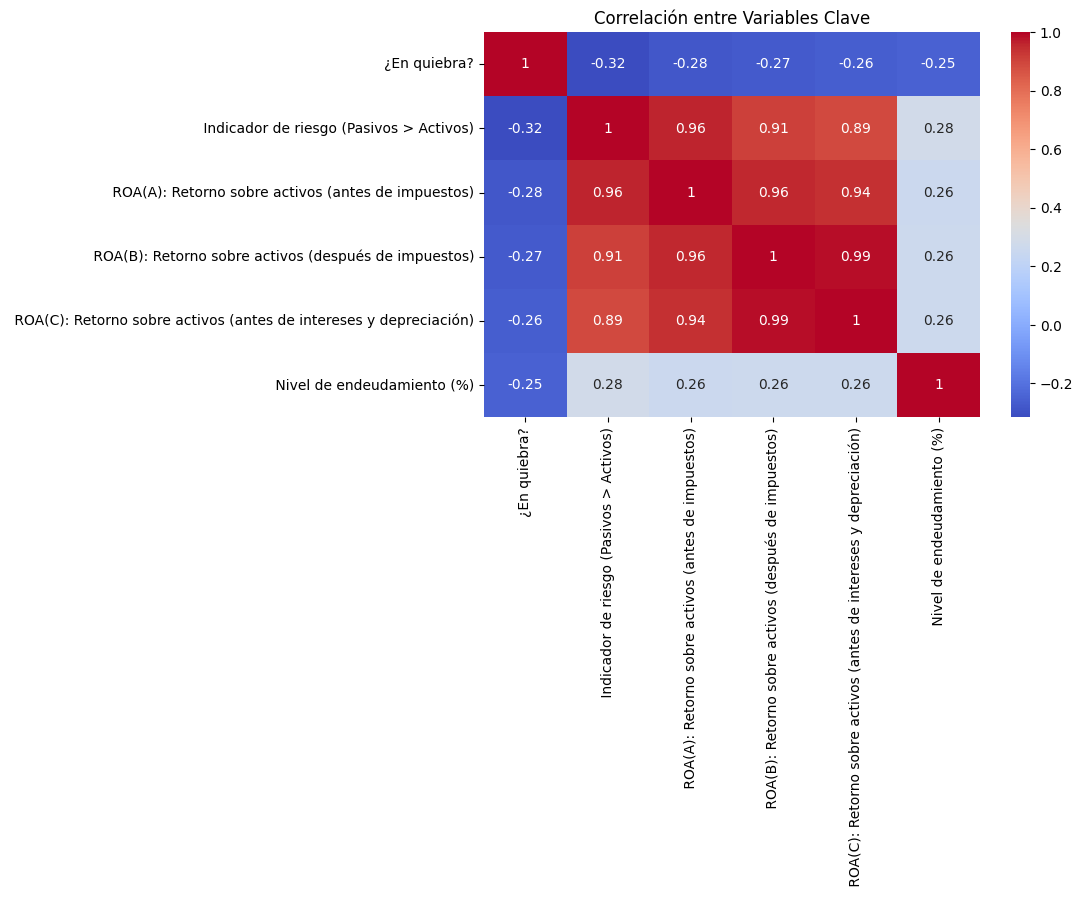

In [43]:
#Top 15 variables correlacionadas con quiebra
corr_target = df.corr()['¿En quiebra?'].abs().sort_values(ascending=False)
print("\nTop 15 variables correlacionadas con quiebra:\n", corr_target[1:16])  # Excluye la variable objetivo

# Heatmap de correlaciones
plt.figure(figsize=(8, 5))
sns.heatmap(df[corr_target.index[:6]].corr(), annot=True, cmap='coolwarm')
plt.title("Correlación entre Variables Clave");

In [47]:
# Opción 1: Lista directa
print(df.columns.tolist())

# Opción 2: Con índice (para ver posición + nombre)
for idx, columna in enumerate(df.columns, 1):
    print(f"{idx}. {columna}")

['¿En quiebra?', ' ROA(C): Retorno sobre activos (antes de intereses y depreciación)', ' ROA(A): Retorno sobre activos (antes de impuestos)', ' ROA(B): Retorno sobre activos (después de impuestos)', ' Margen bruto operativo', ' Margen bruto de ventas realizadas', ' Tasa de beneficio operativo', ' Tasa de interés neto (antes de impuestos)', ' Tasa de interés neto (después de impuestos)', ' Ingresos/gastos no operativos', ' Tasa de interés continua (después de impuestos)', ' % de gastos operativos', ' % de gastos en I+D', ' Ratio de flujo de caja', ' % de deuda con intereses', ' Tasa impositiva (A)', ' Valor contable por acción (B)', ' Valor contable por acción (A)', ' Valor contable por acción (C)', ' EPS persistente (últimos 4 trimestres)', ' Flujo de caja por acción', ' Ingresos por acción (Yuan ¥)', ' Beneficio operativo por acción (Yuan ¥)', ' Beneficio neto por acción (antes de impuestos', ' Yuan ¥)', ' Crecimiento del margen bruto de ventas', ' Crecimiento del beneficio operativo'

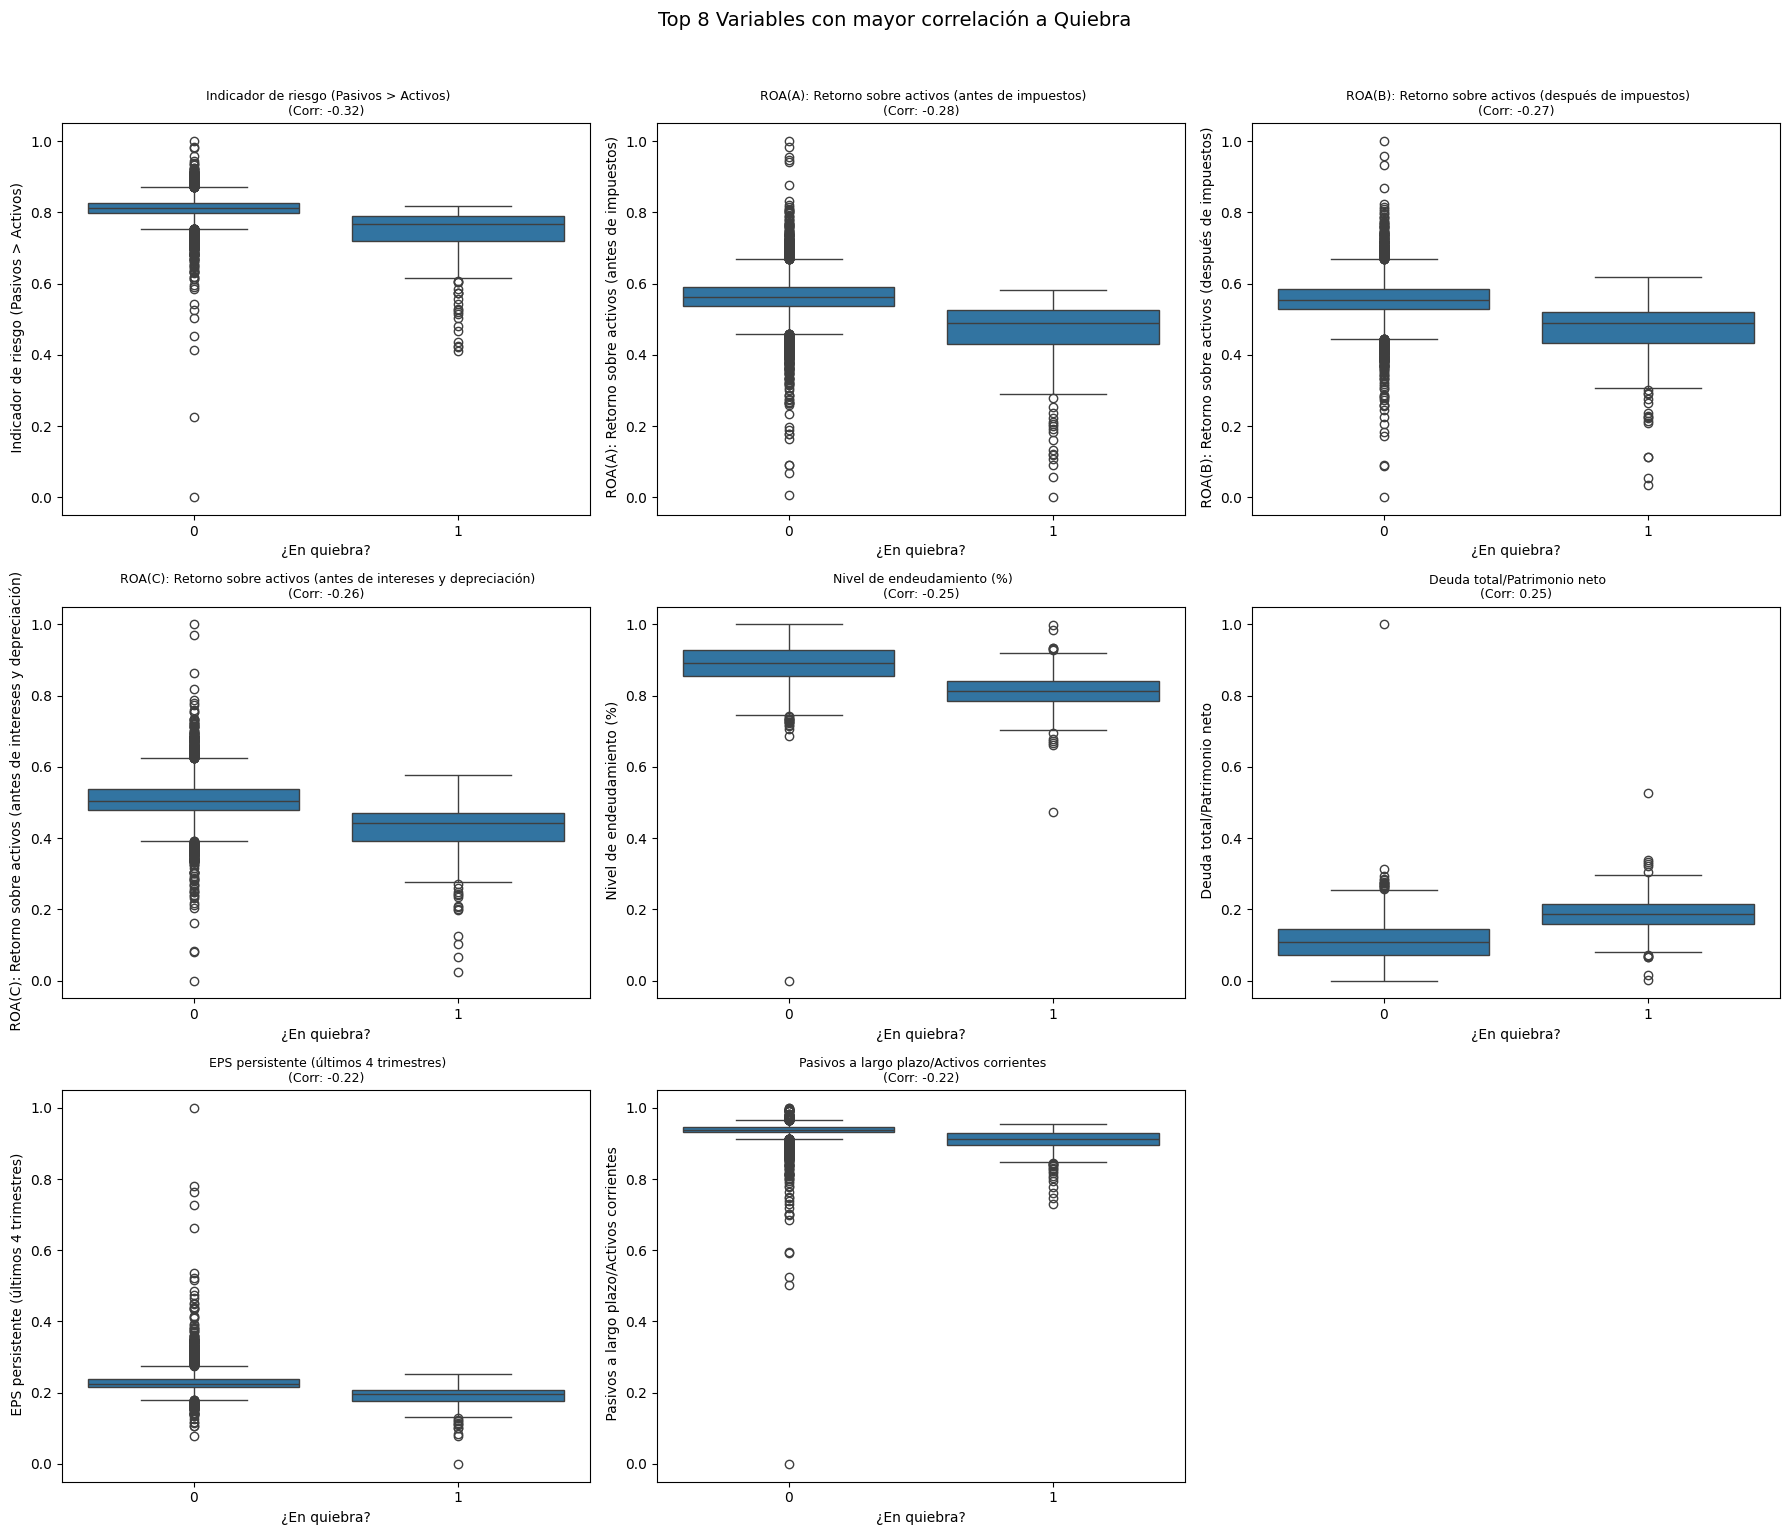

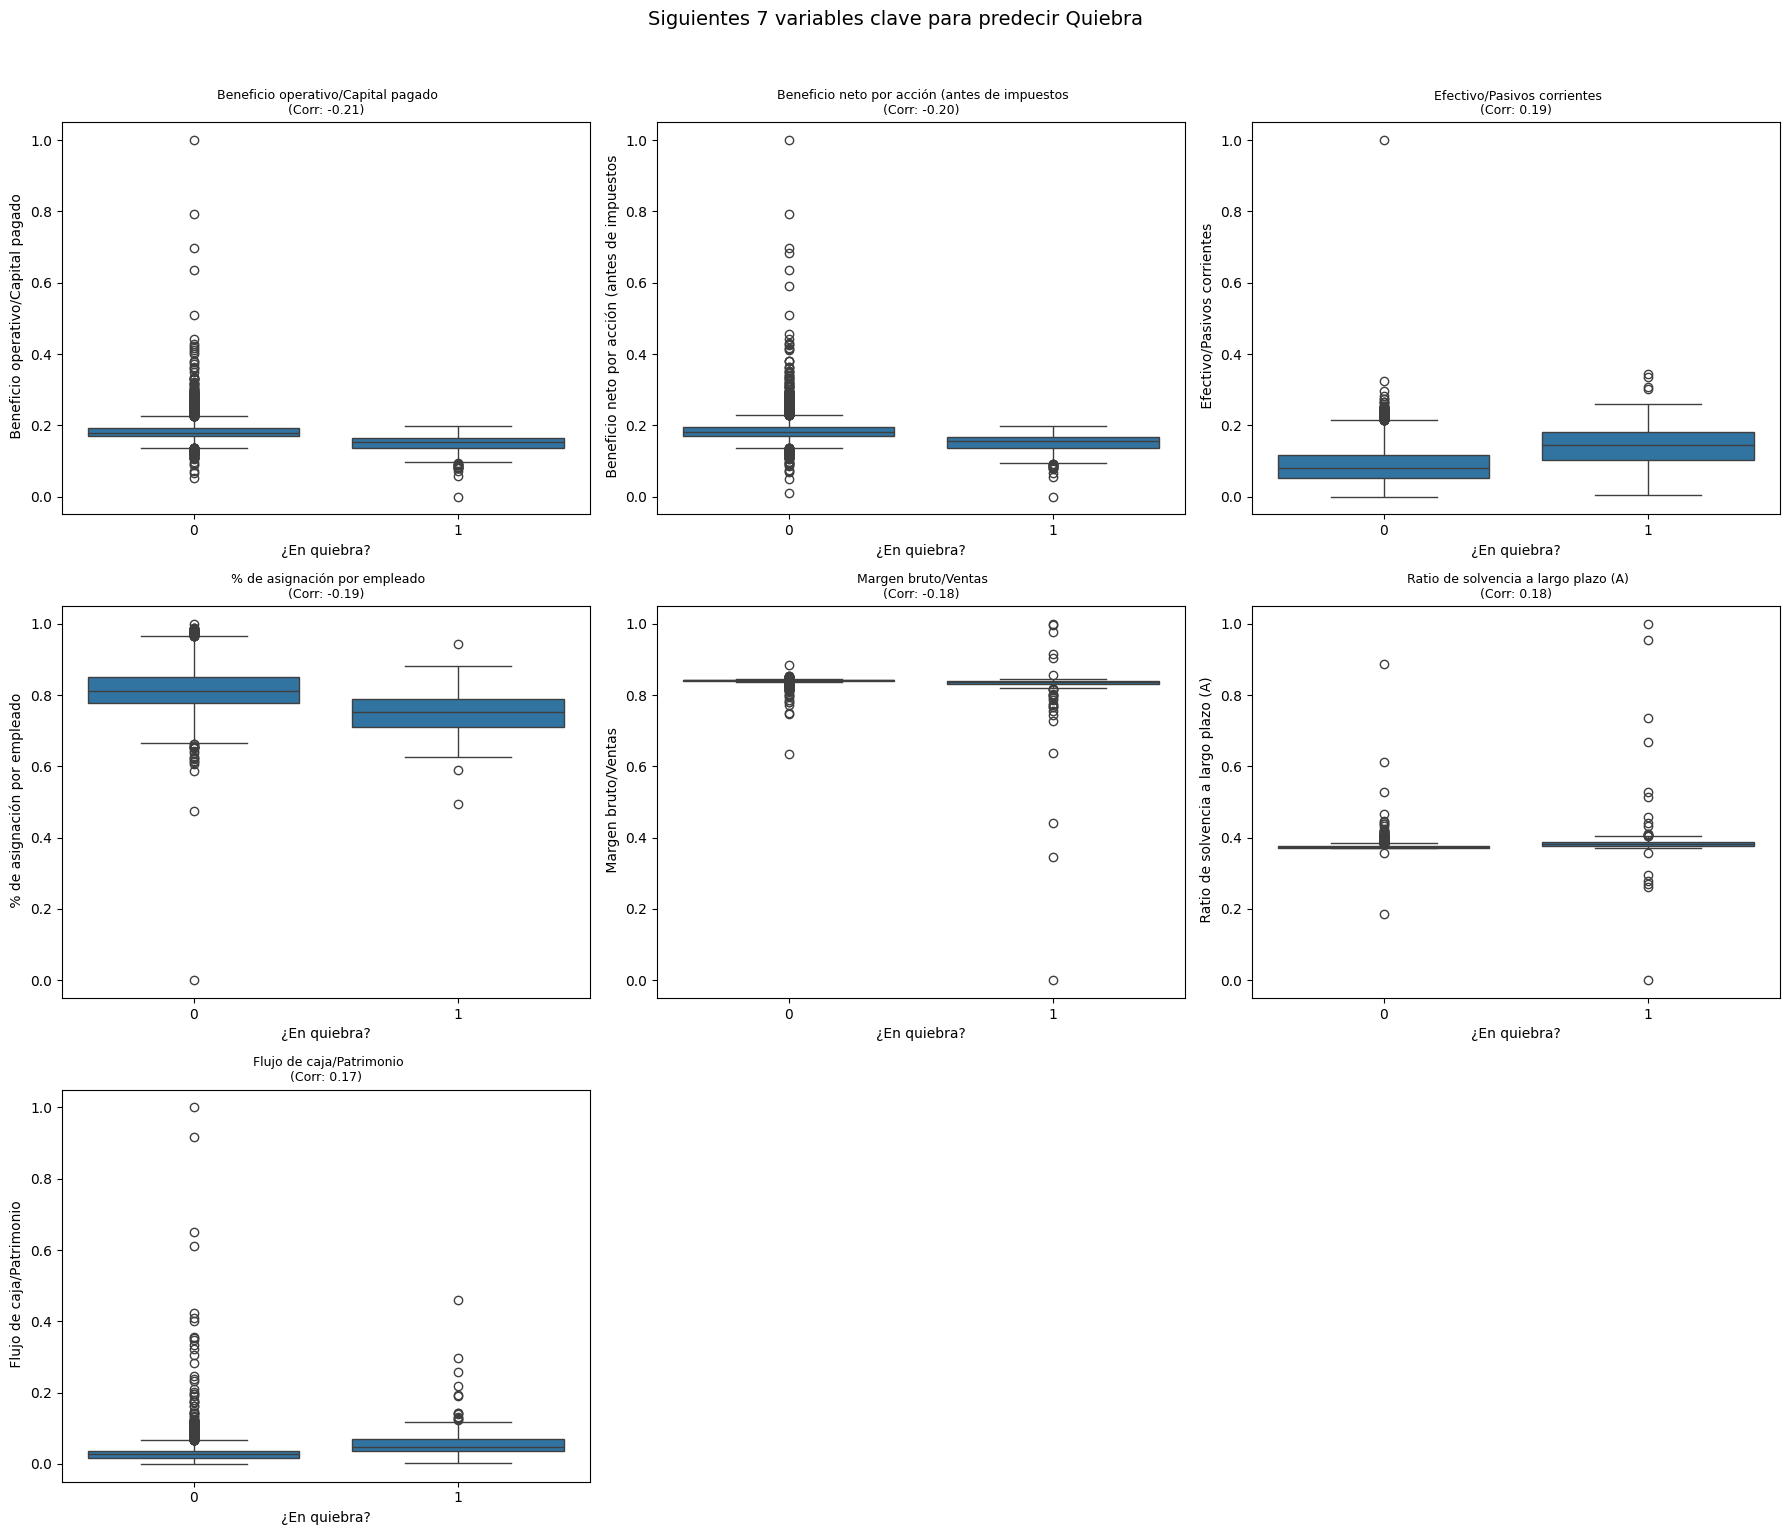

In [53]:
#Distribuimos variables clave
#Recordemos las 15 variables ordenadas por correlación que recien obtuvimos
top_15_vars = [
    ' Indicador de riesgo (Pasivos > Activos)',
    ' ROA(A): Retorno sobre activos (antes de impuestos)',
    ' ROA(B): Retorno sobre activos (después de impuestos)',
    ' ROA(C): Retorno sobre activos (antes de intereses y depreciación)',
    ' Nivel de endeudamiento (%)',
    ' Deuda total/Patrimonio neto',
    ' EPS persistente (últimos 4 trimestres)',
    ' Pasivos a largo plazo/Activos corrientes',
    ' Beneficio operativo/Capital pagado',
    ' Beneficio neto por acción (antes de impuestos',
    ' Efectivo/Pasivos corrientes',
    ' % de asignación por empleado',
    ' Margen bruto/Ventas',
    ' Ratio de solvencia a largo plazo (A)',
    ' Flujo de caja/Patrimonio'
]

# Dividimos las variables en 2 grupos para 2 figuras
grupo1 = top_15_vars[:8]  # Primera figura: 8 variables (3x3)
grupo2 = top_15_vars[8:]  # Segunda figura: 7 variables (3x3)

# Función para generar los plots
def plot_variables(variables, title):
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.ravel()
    for i, var in enumerate(variables):
        sns.boxplot(x='¿En quiebra?', y=var, data=df, ax=axes[i])
        axes[i].set_title(f'{var}\n(Corr: {df[var].corr(df["¿En quiebra?"]):.2f})', fontsize=9)
    # Ocultar ejes vacíos
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Generar las figuras
plot_variables(grupo1, 'Top 8 Variables con mayor correlación a Quiebra')
plot_variables(grupo2, 'Siguientes 7 variables clave para predecir Quiebra')

In [64]:
# Identificar columnas completamente nulas
null_cols = df.columns[df.isnull().all()].tolist()
print("Columnas completamente nulas:", null_cols)

# Eliminarlas antes de continuar (si las hay)
if null_cols:
    df = df.drop(columns=null_cols)
    print(f"Se eliminaron {len(null_cols)} columnas nulas.")

# Creación de nuevos features (¡bien hecho!)
df[' Liquidez vs Endeudamiento'] = df[' Ratio corriente'] / (df[' Deuda total/Patrimonio neto'] + 1e-6)
df[' Eficiencia Operativa'] = df[' Rotación de activos totales'] * df[' Margen bruto operativo']
df[' Solvencia Global'] = df[' Ratio corriente'] + df[' Ratio de solvencia a largo plazo (A)']

# Preparación para el modelo
X = df.drop('¿En quiebra?', axis=1)
y = df['¿En quiebra?']
feature_names = X.columns  # Guardamos los nombres

# Imputación (sin perder nombres)
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=feature_names)

# Selección de features
selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X_imputed, y)

# Nombres de features seleccionadas
selected_features = feature_names[selector.get_support()]
print("\nTop 20 features predictivas:\n", selected_features)

Columnas completamente nulas: [' Patrimonio/Pasivos']
Se eliminaron 1 columnas nulas.

Top 20 features predictivas:
 Index([' ROA(C): Retorno sobre activos (antes de intereses y depreciación)',
       ' ROA(A): Retorno sobre activos (antes de impuestos)',
       ' ROA(B): Retorno sobre activos (después de impuestos)',
       ' Valor contable por acción (B)', ' Valor contable por acción (A)',
       ' Valor contable por acción (C)',
       ' EPS persistente (últimos 4 trimestres)',
       ' Beneficio neto por acción (antes de impuestos',
       ' Deuda total/Patrimonio neto', ' Nivel de endeudamiento (%)',
       ' Ratio de solvencia a largo plazo (A)',
       ' Beneficio operativo/Capital pagado', ' % de asignación por empleado',
       ' Efectivo/Pasivos corrientes',
       ' Pasivos a largo plazo/Activos corrientes',
       ' Pasivos corrientes/Pasivos totales.1', ' Flujo de caja/Patrimonio',
       ' Indicador de riesgo (Pasivos > Activos)', ' Margen bruto/Ventas',
       ' Benefici

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
